<a href="https://colab.research.google.com/github/johnathanhager/Applied-Ai-Midterm/blob/main/appliedai_midterm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install detectron2

In [37]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core

!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
fatal: destination path 'detectron2' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [25]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0
torch:  1.12 ; cuda:  cu113
detectron2: 0.6


In [38]:
# Some basic setup:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# Extras
from IPython.display import Image

from google.colab import output

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,10))

from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

<Figure size 720x720 with 0 Axes>

# Java script function that will take a picture for us

In [39]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      // await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

# Function to take a photo and save it then run the masking/keypoints/panoptic_seg

In [57]:
def take_pic():
  filename = take_photo()
  print('Saved to {}'.format(filename))
    

  im = cv2.imread("./photo.jpg")
  im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
  return im
def mask_rcnn(im):
  # Mask RCNN
  cfg = get_cfg()
  cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
  cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8  # set threshold for this model
  cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
   
  predictor = DefaultPredictor(cfg)
    
  outputs = predictor(im)
  output.clear()

  v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=0.8) # 1.2

  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  plt.imshow(out.get_image()[:, :, ::-1])
  plt.show() 

def keypoints(im):
  # Keypoints
  cfg = get_cfg()
  cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
  cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
  cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")

  predictor = DefaultPredictor(cfg)

  outputs = predictor(im)

  v = Visualizer(im[:,:,::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)

  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  plt.imshow(out.get_image()[:, :, ::-1])
  plt.show()

def panoptic_seg(im):
  # Panoptic segmentation model
  cfg = get_cfg()
  cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"))
  cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")

  predictor = DefaultPredictor(cfg)

  panoptic_seg, segments_info = predictor(im)["panoptic_seg"]
    
  v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
    
  out = v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), segments_info)
  plt.imshow(out.get_image()[:, :, ::-1])
  plt.show()

# Run the function once

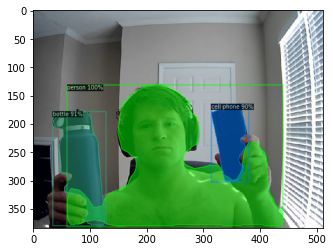

/content/detectron2/detectron2/structures/keypoints.py:224: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  y_int = (pos - x_int) // w


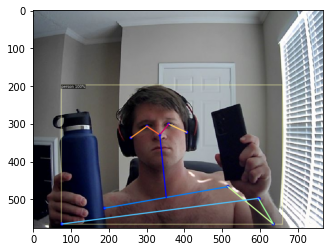

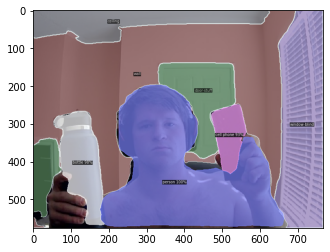

In [62]:
im = take_pic()
mask_rcnn(im)
keypoints(im)
panoptic_seg(im)

# Run the function infinitly to simulate real time.

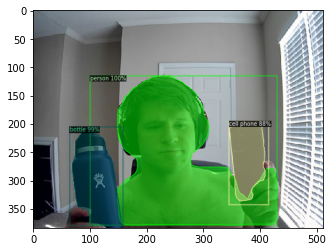

<IPython.core.display.Javascript object>

Saved to photo.jpg


KeyboardInterrupt: ignored

In [66]:
while(True):
  im = take_pic()
  mask_rcnn(im)
  # keypoints(im)
  # panoptic_seg(im)